# Libraries

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack, csr_matrix
import re
import nltk
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/afzalkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading the Data

Train shape: (1697533, 9)
Test shape: (212192, 2)
train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TR

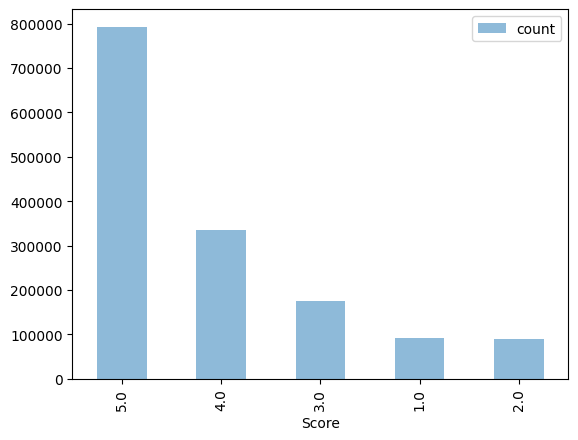


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [36]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Feature Engineering

In [37]:
# Sample a fraction of the training data for efficiency
def sample_training_data(train_df, fraction=0.1, random_state=42):
    return train_df.sample(frac=fraction, random_state=random_state)

# Add new features to the dataset
def add_features_to(df):
    df['HelpfulnessDenominator'] = df['HelpfulnessDenominator'].replace(0, np.nan)
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['Summary'] = df['Summary'].fillna('')
    df['Text'] = df['Text'].fillna('')
    df['Summary_length'] = df['Summary'].str.len()
    df['Text_length'] = df['Text'].str.len()
    return df


# Preprocessing

In [38]:
# Extract test data based on IDs
def extract_test_data(train_df, test_df):
    test_ids = test_df['Id'].unique()
    test_data = train_df[train_df['Id'].isin(test_ids)].copy()
    return add_features_to(test_data).reset_index(drop=True)

In [39]:
def preprocess_text_simple(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    # Remove stop words
    words = [word for word in text.split() if word not in stop_words]
    # Join words back into one string
    return ' '.join(words)


train_sample['Combined_Text'] = train_sample['Summary'] + ' ' + train_sample['Text']
test_data['Combined_Text'] = test_data['Summary'] + ' ' + test_data['Text']
train_sample['Cleaned_Text'] = train_sample['Combined_Text'].apply(preprocess_text_simple)
test_data['Cleaned_Text'] = test_data['Combined_Text'].apply(preprocess_text_simple)


In [40]:
# Preprocess text by removing non-alphabetic characters, converting to lowercase, and removing stop words
def preprocess_text_simple(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

# Combine and clean text fields in train and test data
def preprocess_combined_text(data):
    data['Combined_Text'] = data['Summary'] + ' ' + data['Text']
    data['Cleaned_Text'] = data['Combined_Text'].apply(preprocess_text_simple)
    return data

In [41]:
# Vectorize text data using TF-IDF
def vectorize_text_data(train_text, test_text, max_features=5000, ngram_range=(1,2)):
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    combined_text = pd.concat([train_text, test_text], axis=0)
    tfidf_combined_text = tfidf_vectorizer.fit_transform(combined_text)
    tfidf_train = tfidf_combined_text[:len(train_text)]
    tfidf_test = tfidf_combined_text[len(train_text):]
    return tfidf_train, tfidf_test


In [42]:
# Vectorize text data using TF-IDF
def vectorize_text_data(train_text, test_text, max_features=5000, ngram_range=(1,2)):
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    combined_text = pd.concat([train_text, test_text], axis=0)
    tfidf_combined_text = tfidf_vectorizer.fit_transform(combined_text)
    tfidf_train = tfidf_combined_text[:len(train_text)]
    tfidf_test = tfidf_combined_text[len(train_text):]
    return tfidf_train, tfidf_test


In [43]:
# Prepare numeric features and combine them with TF-IDF features
def prepare_features(train_df, test_df, tfidf_train, tfidf_test):
    numeric_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'Summary_length', 'Text_length']
    X_train_numeric = train_df[numeric_features].fillna(0).reset_index(drop=True)
    X_test_numeric = test_df[numeric_features].fillna(0).reset_index(drop=True)
    X_train_combined = hstack([tfidf_train, csr_matrix(X_train_numeric.values)])
    X_test_combined = hstack([tfidf_test, csr_matrix(X_test_numeric.values)])
    return X_train_combined, X_test_combined


In [44]:
# Perform hyperparameter tuning using GridSearchCV
def tune_logistic_regression(X_train, y_train, param_grid, class_weights='balanced', max_iter=500, cv=3):
    grid_search = GridSearchCV(
        LogisticRegression(max_iter=max_iter, class_weight=class_weights),
        param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print("Best parameters found: ", grid_search.best_params_)
    return grid_search.best_estimator_

In [45]:
# Evaluate model on validation set
def evaluate_model(model, X_valid, y_valid):
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print("Validation Accuracy:", accuracy)
    return accuracy


In [46]:
# Train final model on complete training data and make predictions on test data
def train_and_predict_final_model(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_test)


In [47]:
# Prepare submission file
def create_submission_file(test_df, predictions, filename='submission.csv'):
    submission = test_df[['Id']].copy()
    submission['Score'] = predictions
    submission.to_csv(filename, index=False)
    print("Submission file created successfully!")


In [48]:

# Plot a confusion matrix
def plot_confusion_matrix(Y_true, Y_pred):
    cm = confusion_matrix(Y_true, Y_pred, normalize='true')  # Normalize to show proportions
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
    plt.title('Confusion Matrix of the Classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

/Users/afzalkhan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/afzalkhan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/afzalkhan/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best parameters found:  {'C': 10, 'l1_ratio': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
Validation Accuracy: 0.6326503136864213


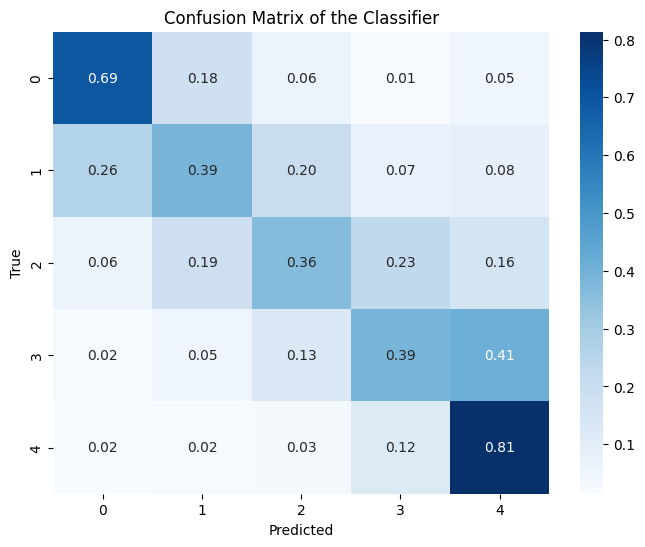

Submission file created successfully!


In [49]:
# Updated main function to include confusion matrix plotting
def main(train_df, test_df):
    # Sample and add features to training data
    train_sample = sample_training_data(train_df)
    train_sample = add_features_to(train_sample).reset_index(drop=True)

    # Prepare test data
    test_data = extract_test_data(train_df, test_df)

    # Preprocess text fields
    train_sample = preprocess_combined_text(train_sample)
    test_data = preprocess_combined_text(test_data)

    # Vectorize text data
    tfidf_train, tfidf_test = vectorize_text_data(train_sample['Cleaned_Text'], test_data['Cleaned_Text'])

    # Prepare combined features
    X_train_combined, X_test_combined = prepare_features(train_sample, test_data, tfidf_train, tfidf_test)
    y_train = train_sample['Score']

    # Split training data for validation
    X_train_part, X_valid, y_train_part, y_valid = train_test_split(
        X_train_combined, y_train, test_size=0.25, random_state=42)

    # Parameter grid for Logistic Regression
    param_grid = {'C': [10], 'solver': ['liblinear'], 'penalty': ['l2'], 'l1_ratio': [0.5]}

    # Filter out NaN values from training/validation data
    X_train_part = X_train_part[~y_train_part.isna()]
    y_train_part = y_train_part[~y_train_part.isna()]
    X_valid = X_valid[~y_valid.isna()]
    y_valid = y_valid[~y_valid.isna()]

    # Tune Logistic Regression and evaluate on validation data
    best_model = tune_logistic_regression(X_train_part, y_train_part, param_grid)
    evaluate_model(best_model, X_valid, y_valid)

    # Plot confusion matrix
    y_valid_pred = best_model.predict(X_valid)
    plot_confusion_matrix(y_valid, y_valid_pred)

    # Train on complete data and predict on test data
    nan_mask = ~y_train.isna()
    X_train_combined = X_train_combined[nan_mask]
    y_train = y_train[nan_mask]
    predictions = train_and_predict_final_model(best_model, X_train_combined, y_train, X_test_combined)

    # Create and save submission file
    create_submission_file(test_df, predictions)

# Execute main function
main(train_df, test_df)



# Creating Submission File